# Quantifying and Combining Crypto Alphas

In this article, I'll take some crypto stat arb features from our recent brainstorming article and show you how you might quantify their strength and decay characteristics and then combine them into a trading signal. 

This article continues our recent articles on stat arb:

- [A short take on stat arb trading in the real world](https://robotwealth.com/a-short-take-on-real-world-pairs-trading/)
- [A general approach for exploiting stat arb alphas](https://robotwealth.com/a-general-approach-for-exploiting-statistical-arbitrage-alphas/)
- [Ideas for crypto stat arb features](https://robotwealth.com/ideas-for-crypto-stat-arb-features/)

Ultimately, combining signals is about making sensible decisions about how you want each signal to contribute to the calculation of portfolio weights. And to make those decisions, you need to understand your signals:
- Do they need to be scaled or transformed in some way to be useful?
- How strongly are they predictive of forward returns?
- How quickly does this predictive power decay?
- How noisy is the signal? Does it bounce around all over the place or is it relatively stable?
- How correlated are your signals to one another?

One you understand these questions, you can start to consider how to combine your signals. And there are no right or wrong answers, just different paths through the various trade-offs depending on your goals and constraints. When considering costs, the questions around signal decay and stability become critical. 

And you might combine your signals using simple heuristics (equal weight, equal volatility contribution), or by selecting coefficients based on your understanding of how the signals behave. You can also use explicit optimisation techniques, but you don't have to. 

In this article, we'll combine some cross-sectional signals with a time-series one, which has the effect of tipping the portfolio net long or short - which may or may not be acceptable depending on your constraints. 

I'll include all the code and link to the data so that you can follow along if you like. 

Let's get to it. 

First, load some libraries and set our session options:

In [142]:
# session  options
options(repr.plot.width = 14, repr.plot.height=7, warn = -1)

library(tidyverse)
library(tibbletime)

# chart options
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Next load some data. This dataset includes daily price, volume, and funding data for crypto perpetual futures contracts traded on Binance since late 2019. 

The data includes a flag `is_universe` which defines which futures were in our analysis universe on a given data. In creating our analysis universe, we essentially just ditched the worst of the worst by:

- excluding anything with a price < 0.01 (arbitrary)
- excluding remaining 20% with lowest trailing monthly volume

You can get the data here.

In [144]:
perps <- read_csv("binance_perp_daily.csv")
head(perps)

Rows: 388765 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (8): open, high, low, close, volume, funding_returns_log, total_returns...
lgl  (1): is_universe
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


date,ticker,open,high,low,close,volume,funding_returns_log,total_returns_simple,total_returns_log,is_universe
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
2019-09-11,ADAUSDT,0.046410,0.047130,0.044380,0.044870,85563306.70,0,-0.034222988,-0.034822307,TRUE
2019-09-11,ALGOUSDT,0.365000,0.372000,0.342000,0.349000,3244647.94,0,-0.043835616,-0.044825431,TRUE
2019-09-11,ANKRUSDT,0.003107,0.003139,0.002929,0.002946,13870079.00,0,-0.051818474,-0.053209312,FALSE
2019-09-11,ATOMUSDT,2.581000,2.708000,2.396000,2.565000,778901.53,0,-0.007352941,-0.007380107,TRUE
2019-09-11,BATUSDT,0.172300,0.175000,0.167800,0.170400,1739747.11,0,-0.009877978,-0.009927089,TRUE
2019-09-11,BCHABCUSDT,304.040000,307.610000,291.880000,299.050000,35296.25,0,-0.016865014,-0.017008848,FALSE


First, how many perps are in our universe?

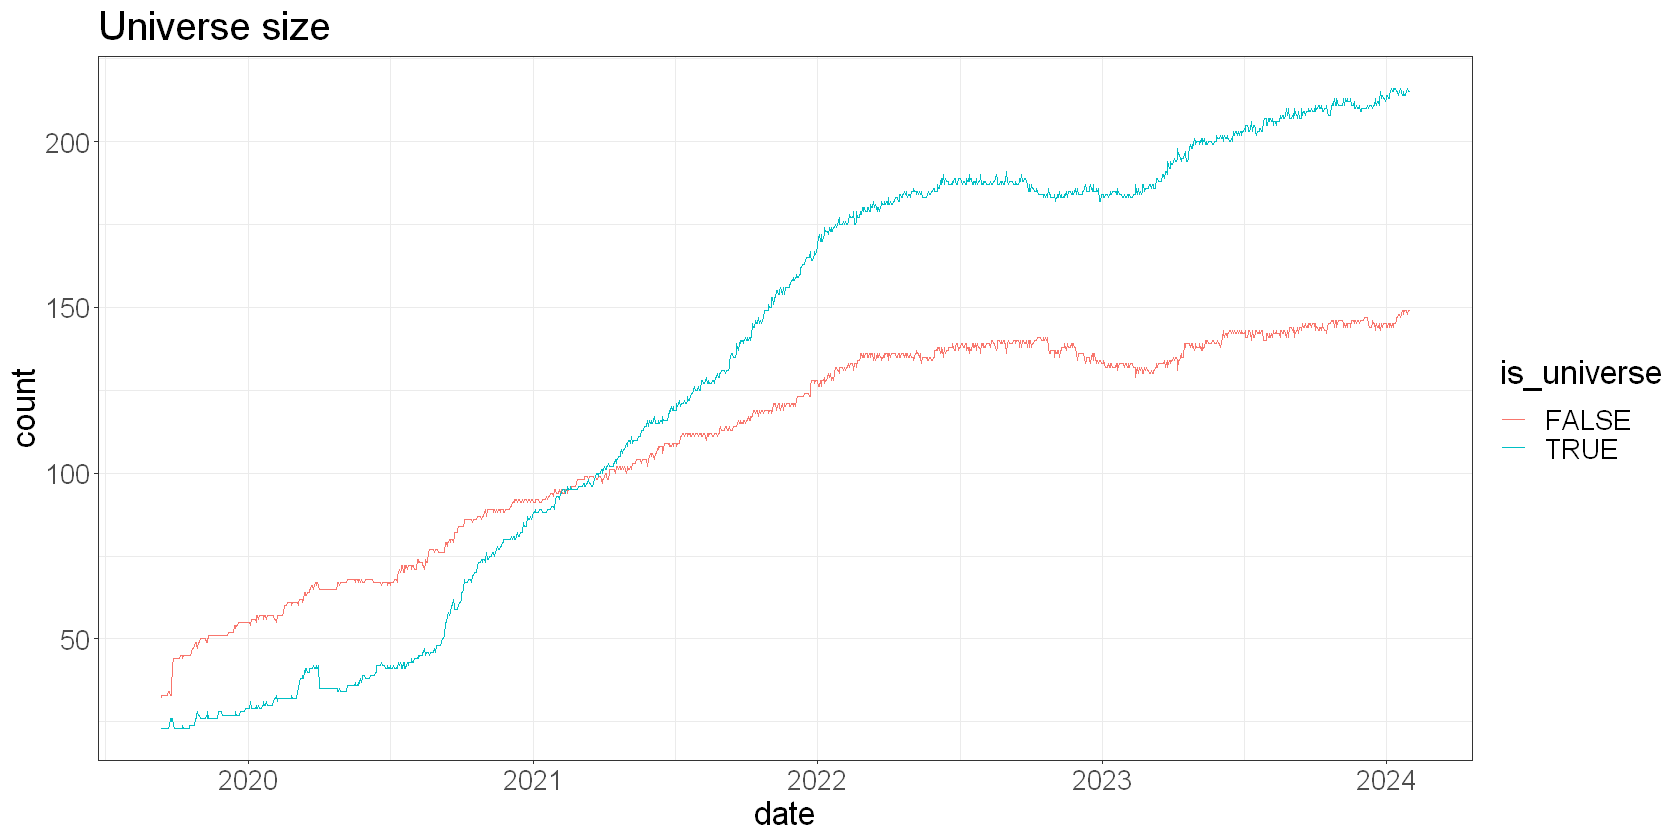

In [145]:
perps %>%
  group_by(date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  ggplot(aes(x=date, y=count, color = is_universe)) + 
  geom_line() + 
  labs(
    title = 'Universe size'
)

## Some simple features

We'll look at three very simple features implied by our [brainstorming session](https://robotwealth.com/ideas-for-crypto-stat-arb-features/).

- Breakout - closeness to recent 20 day highs: (9.5 = new highs today / -9.5 = new highs 20 days ago)
- Carry - funding over the last 24 hours
- Momentum - how much has price changed over the last 10 days

My intent is to use the carry and momentum features as cross-sectional predictors of returns. That is, does relative carry/momentum predict out/under-performance?

And I'll use the breakout feature as a time-series overlay. I hope to use it to predict forward returns for each asset in the time-series, not in the cross-section. 

This is mostly to demonstrate how to combine cross-sectional and time-series features into a single long-short strategy. Adding time-series features to a long-short stat arb basket has the effect of making the basket net long or net short rather than delta neutral, so you may not want to do it, depending on your constraints.

First we calculate the raw features and lag them by one observation:

In [146]:
rolling_days_since_high_20 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    }, 
    window = 20, na_value = NA), 
  otherwise = NA
)

features <- perps %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    breakout = lag(9.5 - rolling_days_since_high_20(close)),  # puts this feature on a scale -9.5 to +9.5
    momo = lag(close - lag(close, 10)/close),
    carry = lag(funding_returns_log)
  ) %>%
  ungroup() %>% 
  na.omit()

head(features)

date,ticker,open,high,low,close,volume,funding_returns_log,total_returns_simple,total_returns_log,is_universe,breakout,momo,carry
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
2019-10-01,ADAUSDT,3.888e-02,0.03995,3.809e-02,0.038240,109847393.9,0,-0.01646091,-0.01659789,TRUE,-2.5,-1.312200,0
2019-10-01,ALGOUSDT,2.500e-01,0.26600,2.260e-01,0.231000,14560932.5,0,-0.07600000,-0.07904321,TRUE,-9.5,-1.034000,0
2019-10-01,ANKRUSDT,2.244e-03,0.00242,2.185e-03,0.002289,25625193.0,0,0.02141901,0.02119285,FALSE,-2.5,-1.352958,0
2019-10-01,ATOMUSDT,2.653e+00,2.66100,2.480e+00,2.533000,878221.3,0,-0.04523181,-0.04628670,TRUE,-5.5,1.450211,0
2019-10-01,BATUSDT,1.731e-01,0.17420,1.612e-01,0.164300,2607016.8,0,-0.05083767,-0.05217544,TRUE,-0.5,-1.048737,0
2019-10-01,BCHABCUSDT,2.273e+02,235.71000,2.186e+02,222.570000,109701.7,0,-0.02102485,-0.02124902,FALSE,-2.5,225.963108,0


## Exploring our features

The first thing you'll generally want to do is get a handle on the characteristics of our raw features. How are they distributed? Do their distributions imply the need for scaling?

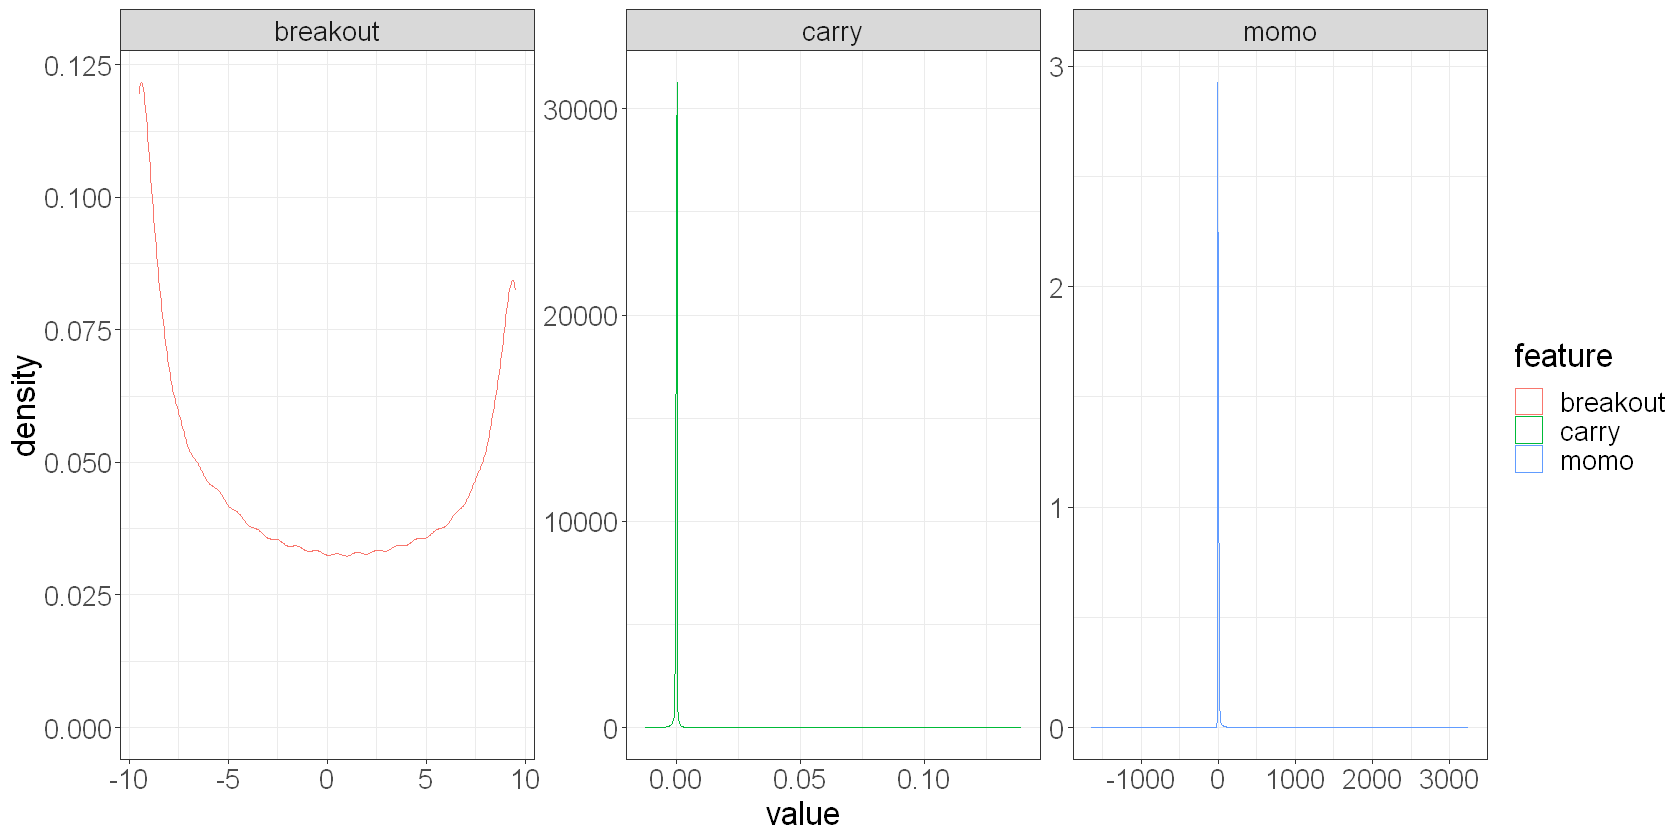

In [147]:
features %>%
  filter(is_universe) %>% 
  pivot_longer(c(breakout, momo, carry), names_to = "feature") %>% 
  ggplot(aes(x = value, colour = feature)) +
  geom_density() +
  facet_wrap(~feature, scales = "free")

We see that the breakout feature is not too badly behaved. Carry and momentum both have significant tails however, so we're going to want to scale those features somehow. 

We'll scale them cross sectionally by:

- calculating a zscore: the number of standard deviations each asset is away from the daily mean
- sorting into deciles: sort the assets into 10 equal buckets by the value of the feature each day - this collapses the feature value down to a rank for each asset each day (multiple assets will have the same rank).

We'll also calculate relative returns so that we can explore our features' predictive utility in the time-series and the cross-section.

In [148]:
features_scaled <- features %>%
  filter(is_universe) %>%
  group_by(date) %>%
  mutate(
    demeaned_returns = total_returns_log - mean(total_returns_log),
    zscore_carry = (carry - mean(carry, na.rm = TRUE)) / sd(carry, na.rm = TRUE),
    decile_carry = ntile(carry, 10),
    zscore_momo = (momo - mean(momo, na.rm = TRUE)) / sd(momo, na.rm = TRUE),
    decile_momo = ntile(momo, 10),
  ) %>% 
  na.omit() %>% 
  ungroup()

Next we would plot our features against next day returns. For example, here's a factor plot of the `decile_carry` feature against next day relative returns:

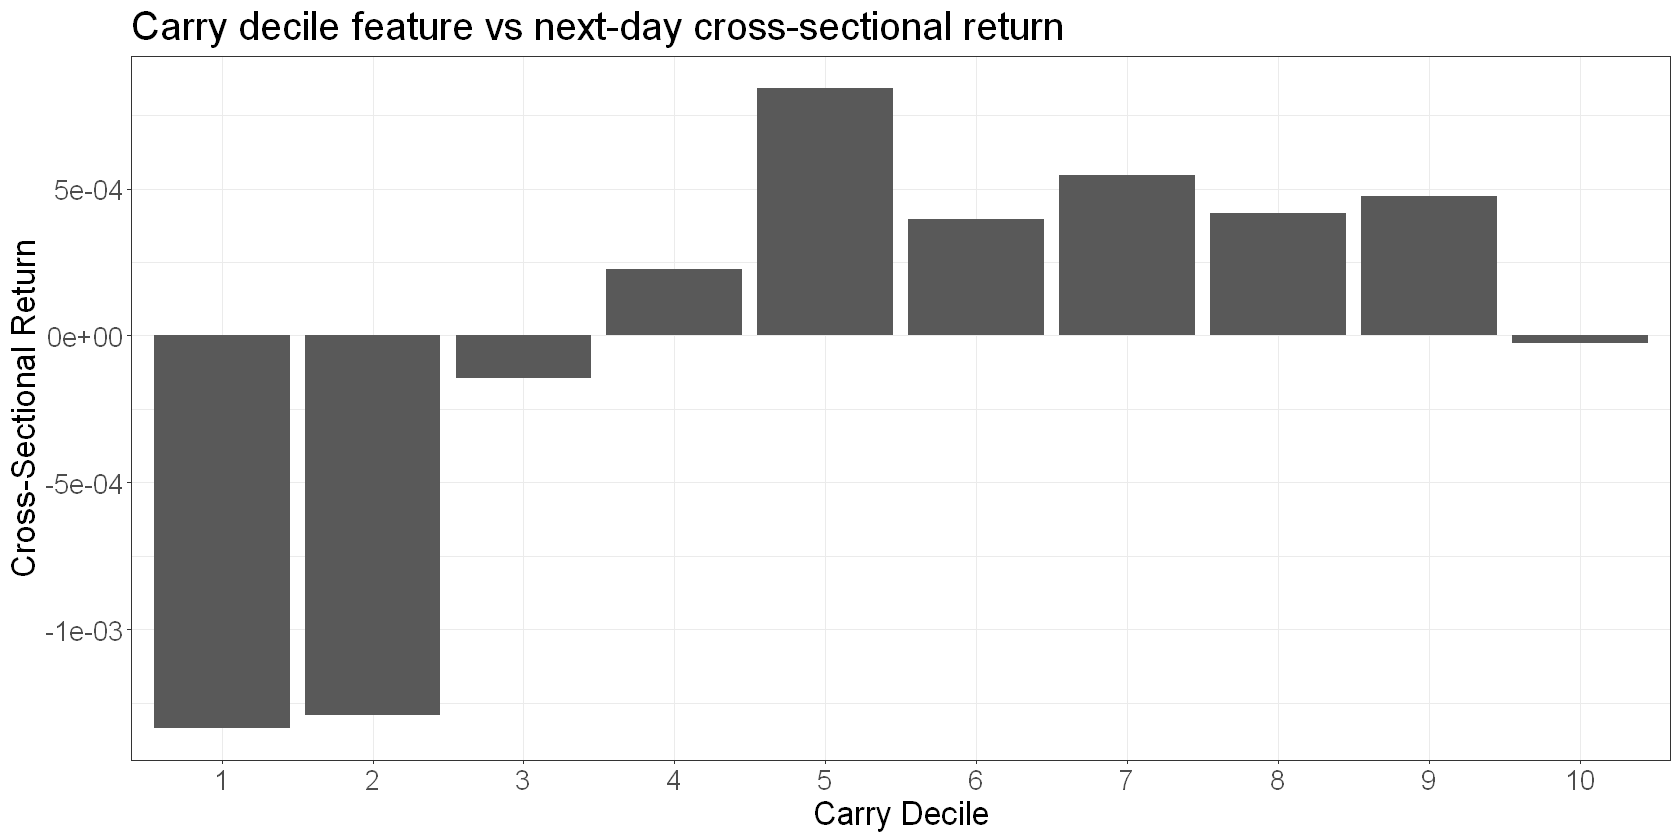

In [151]:
features_scaled %>% 
  group_by(decile_carry) %>%
  summarise(
    mean_return = mean(demeaned_returns)
  ) %>% 
  ggplot(aes(x = factor(decile_carry), y = mean_return)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Carry Decile",
    y = "Cross-Sectional Return",
    title = "Carry decile feature vs next-day cross-sectional return"
  )

We see that it's a reasonable discriminator of the sign of next day returns, but the relationship is not as linear as we would like in an ideal world. 

And here's a scatterplot of the breakout feature against mean next day time-series returns:

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


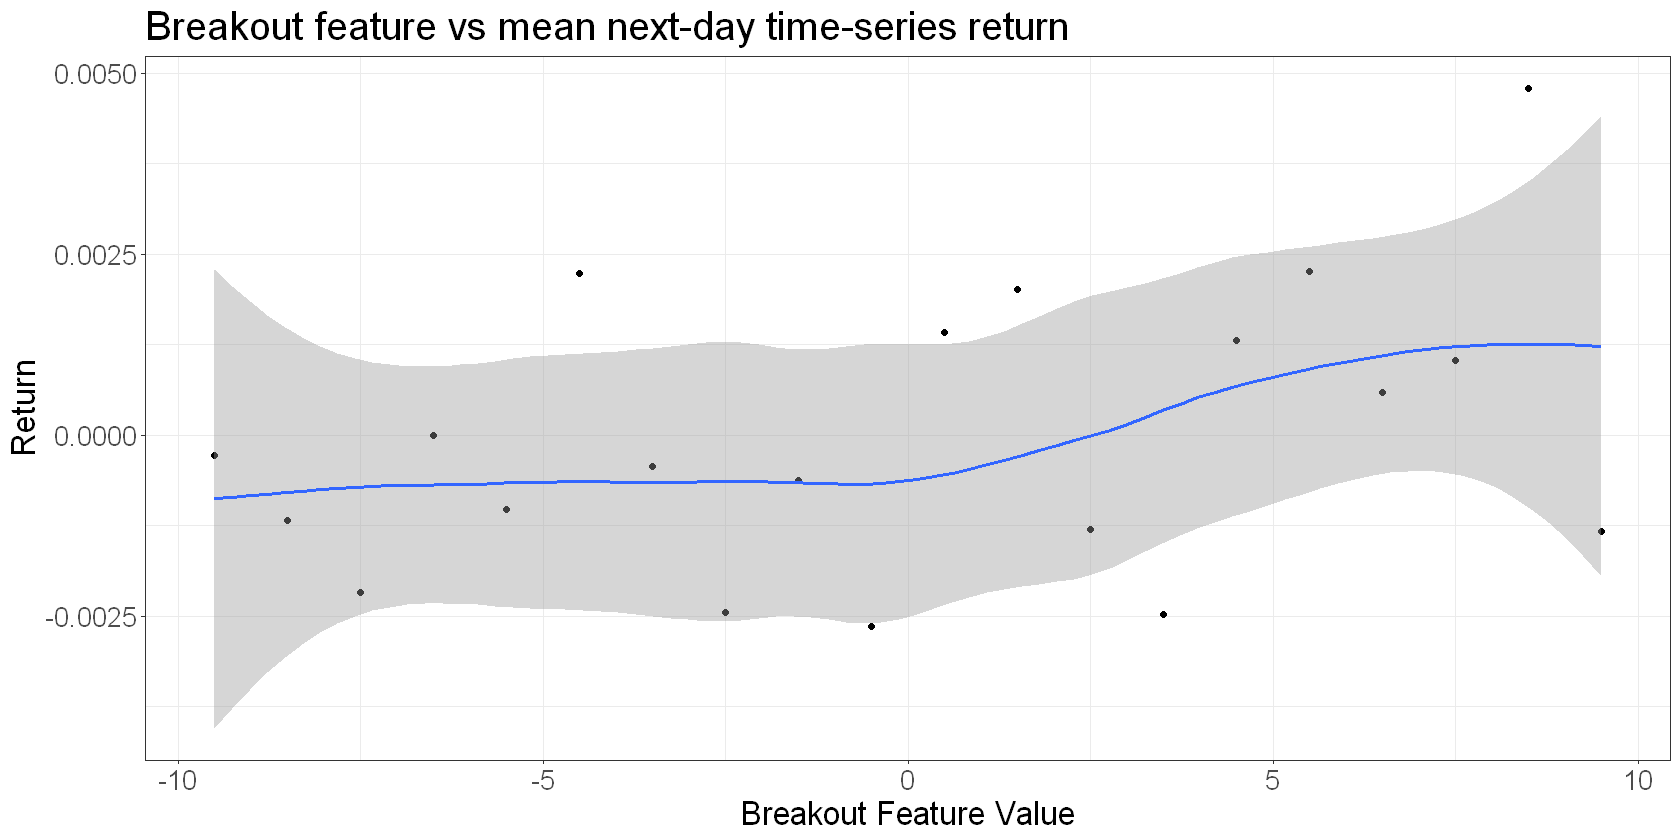

In [156]:
features_scaled %>% 
  group_by(breakout) %>%
  summarise(
    mean_return = mean(total_returns_log)
  ) %>% 
  ggplot(aes(x = breakout, y = mean_return)) +
  geom_point() +
  geom_smooth() +
  labs(
    x = "Breakout Feature Value",
    y = "Return",
    title = "Breakout feature vs mean next-day time-series return"
  )

Again, we see that this feature does a reasonable job of discriminating the sign of returns, but again it's a noisy relationship.

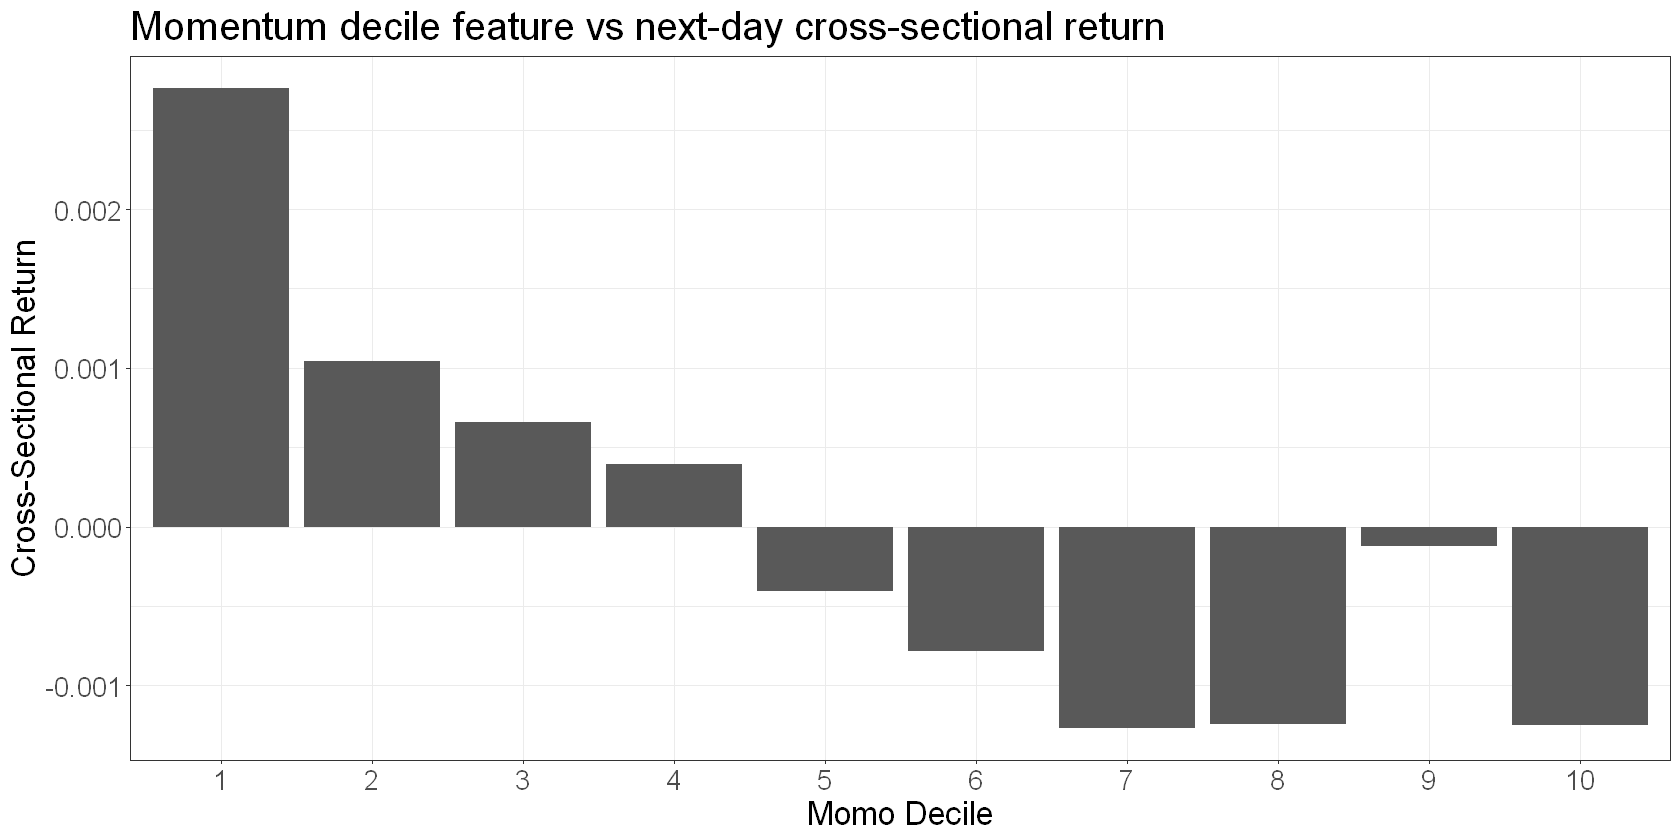

In [158]:
features_scaled %>% 
  group_by(decile_momo) %>%
  summarise(
    mean_return = mean(demeaned_returns)
  ) %>% 
  ggplot(aes(x = factor(decile_momo), y = mean_return)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Momo Decile",
    y = "Cross-Sectional Return",
    title = "Momentum decile feature vs next-day cross-sectional return"
  )

This feature looks really nice. We see a clear relationship between 10-day cross-sectional momentum and next day relative returns. Interestingly, we see a negative relationship, implying a mean-reversion effect rather than momentum. 

### More work to do
There are all sorts of ways you can view your features. 

Here, we've only looked at the mean returns to each discrete feature value, which is useful because by aggregating returns, we get a clear view of the on-average relationships. On the downside however, this approach hides nearly all of the variance. So in practice you'd also rely on other tools - for instance scatterplots and timeseries plots of cumulative next day returns to the feature. 

We've also not looked at turnover implied by our signals. This is crucial when you start to consider costs. 

You'd also want to look at look at the stability of the factors' performance over time. For example, you may want to down-weight factors that outperformed in the past but have levelled off recently. What we've done here hides that level of detail. 

## Information coefficient

The information coefficient is simply the correlation of the feature with next day returns. It provides a single metric for quantifying the strength of the signal. We can calculate it for time-series returns and cross-sectional returns:

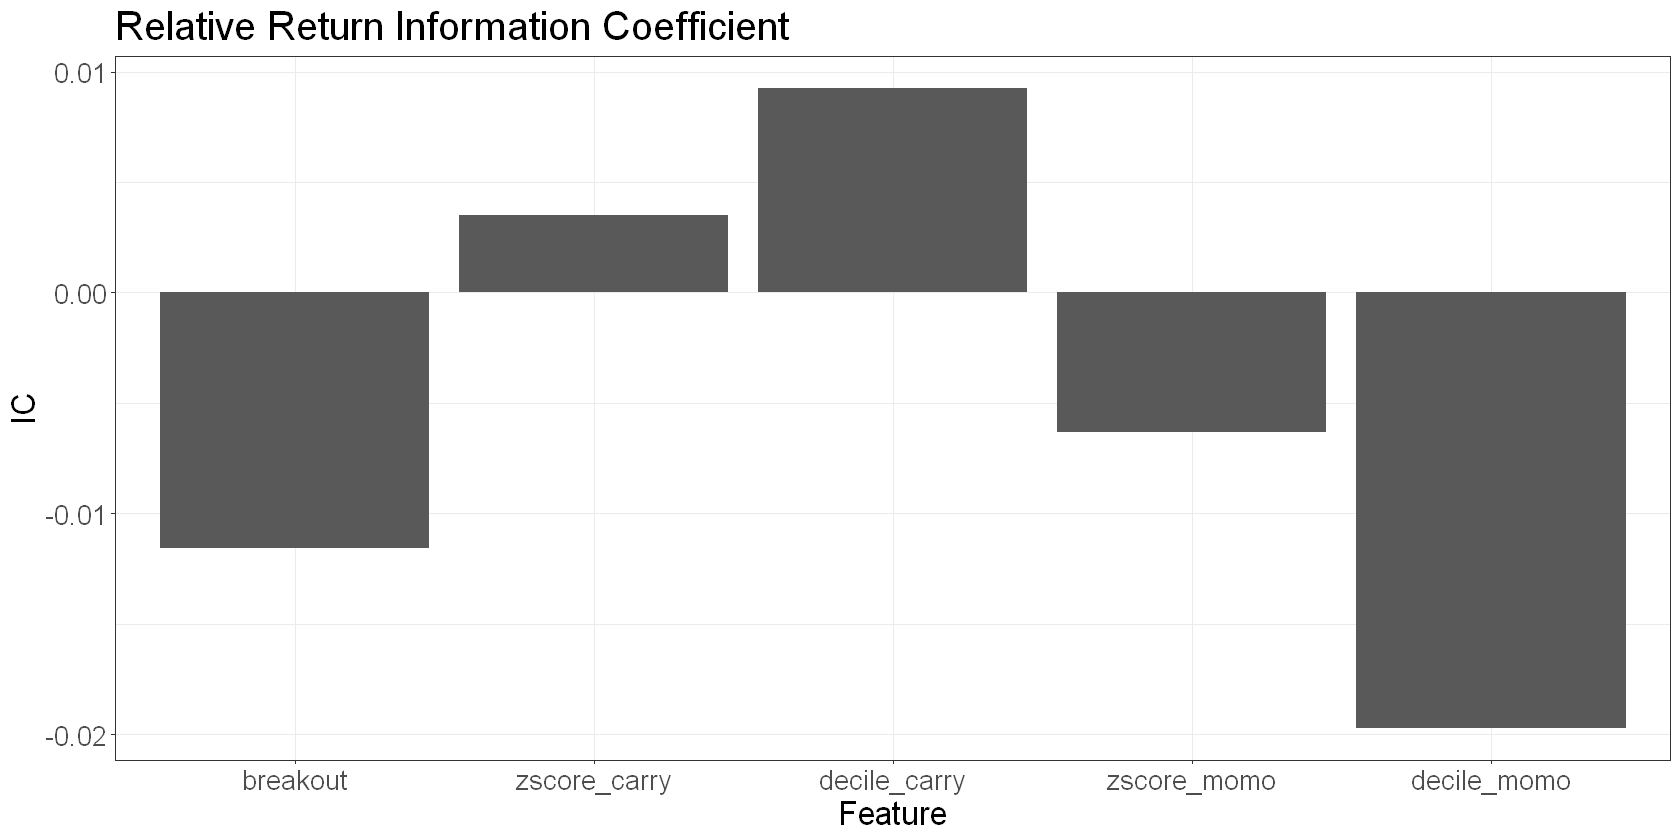

In [164]:
features_scaled %>% 
  pivot_longer(c(breakout, zscore_carry, zscore_momo, decile_carry, decile_momo), names_to = "feature") %>% 
  group_by(feature) %>% 
  summarize(IC = cor(value, demeaned_returns))  %>% 
  ggplot(aes(x = factor(feature, levels = c('breakout', 'zscore_carry', 'decile_carry', 'zscore_momo', 'decile_momo')), y = IC)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Feature",
    y = "IC",
    title = "Relative Return Information Coefficient"
  )

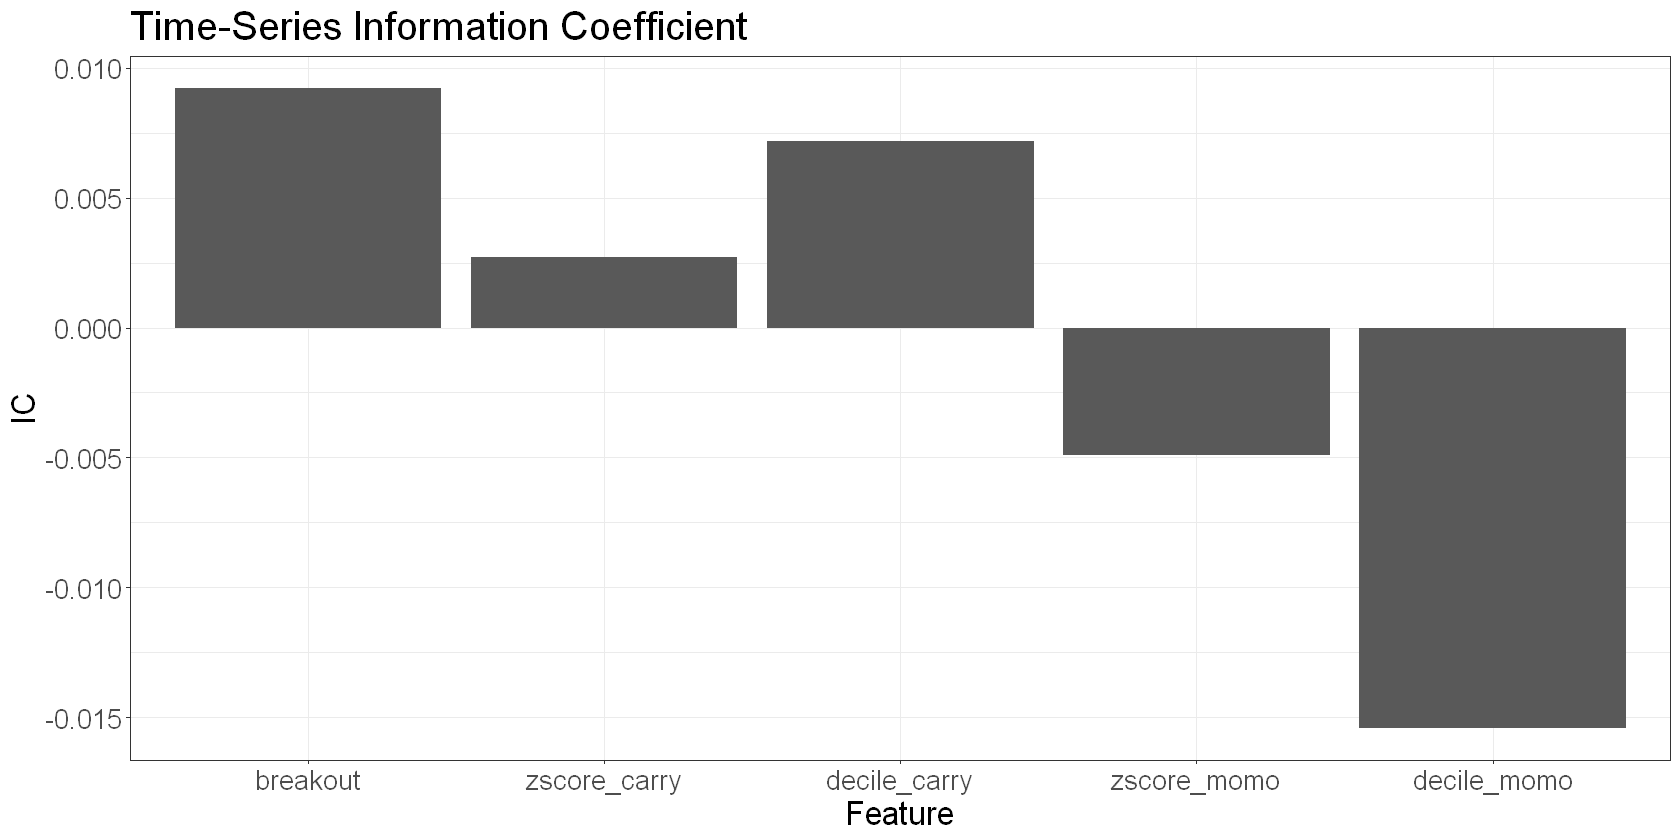

In [165]:
features_scaled %>% 
  pivot_longer(c(breakout, zscore_carry, zscore_momo, decile_carry, decile_momo), names_to = "feature") %>% 
  group_by(feature) %>% 
  summarize(IC = cor(value, total_returns_log))  %>% 
  ggplot(aes(x = factor(feature, levels = c('breakout', 'zscore_carry', 'decile_carry', 'zscore_momo', 'decile_momo')), y = IC)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Feature",
    y = "IC",
    title = "Time-Series Information Coefficient"
  )

## Decay characteristics

Next, it's useful to understand how quickly your signals decay. Signals that decay quickly need to be acted upon without delay, while those that decay slower are more forgiving to execute. 

We'll look at relative return IC for our cross-sectional features and the time-series return IC for our breakout feature. 

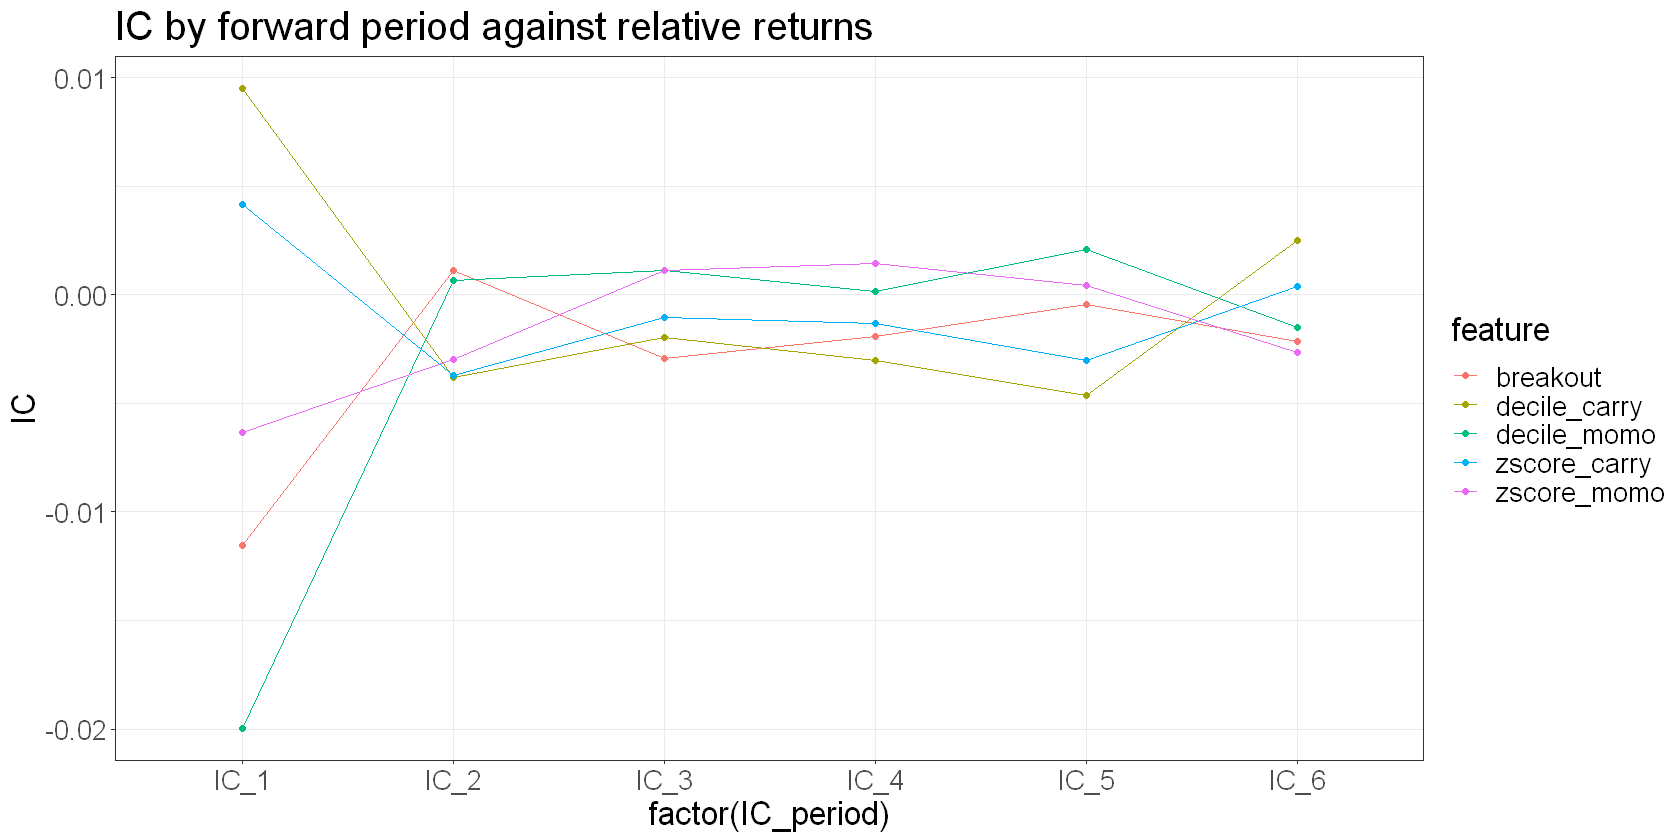

In [171]:
features_scaled %>%
  filter(is_universe) %>%
  group_by(date) %>%
  mutate(
    demeaned_returns = total_returns_log - mean(total_returns_log),
    fwd_demeaned_returns_2 = lead(demeaned_returns, 1),
    fwd_demeaned_returns_3 = lead(demeaned_returns, 2),
    fwd_demeaned_returns_4 = lead(demeaned_returns, 3),
    fwd_demeaned_returns_5 = lead(demeaned_returns, 4),
    fwd_demeaned_returns_6 = lead(demeaned_returns, 5),
  ) %>% 
  na.omit() %>% 
  ungroup() %>% 
  pivot_longer(c(breakout, zscore_carry, zscore_momo, decile_carry, decile_momo), names_to = "feature") %>% 
  group_by(feature) %>% 
  summarize(
    IC_1 = cor(value, demeaned_returns),
    IC_2 = cor(value, fwd_demeaned_returns_2),
    IC_3 = cor(value, fwd_demeaned_returns_3),
    IC_4 = cor(value, fwd_demeaned_returns_4),
    IC_5 = cor(value, fwd_demeaned_returns_5),
    IC_6 = cor(value, fwd_demeaned_returns_6),
  )  %>% 
  pivot_longer(-feature, names_to = "IC_period", values_to = "IC") %>% 
  ggplot(aes(x = factor(IC_period), y = IC, colour = feature, group = feature)) +
  geom_line() +
  geom_point() +
  labs(
    title = "IC by forward period against relative returns"
  )

All of our cross-sectional features decay quite quickly. They all look quite random from about the second day. 

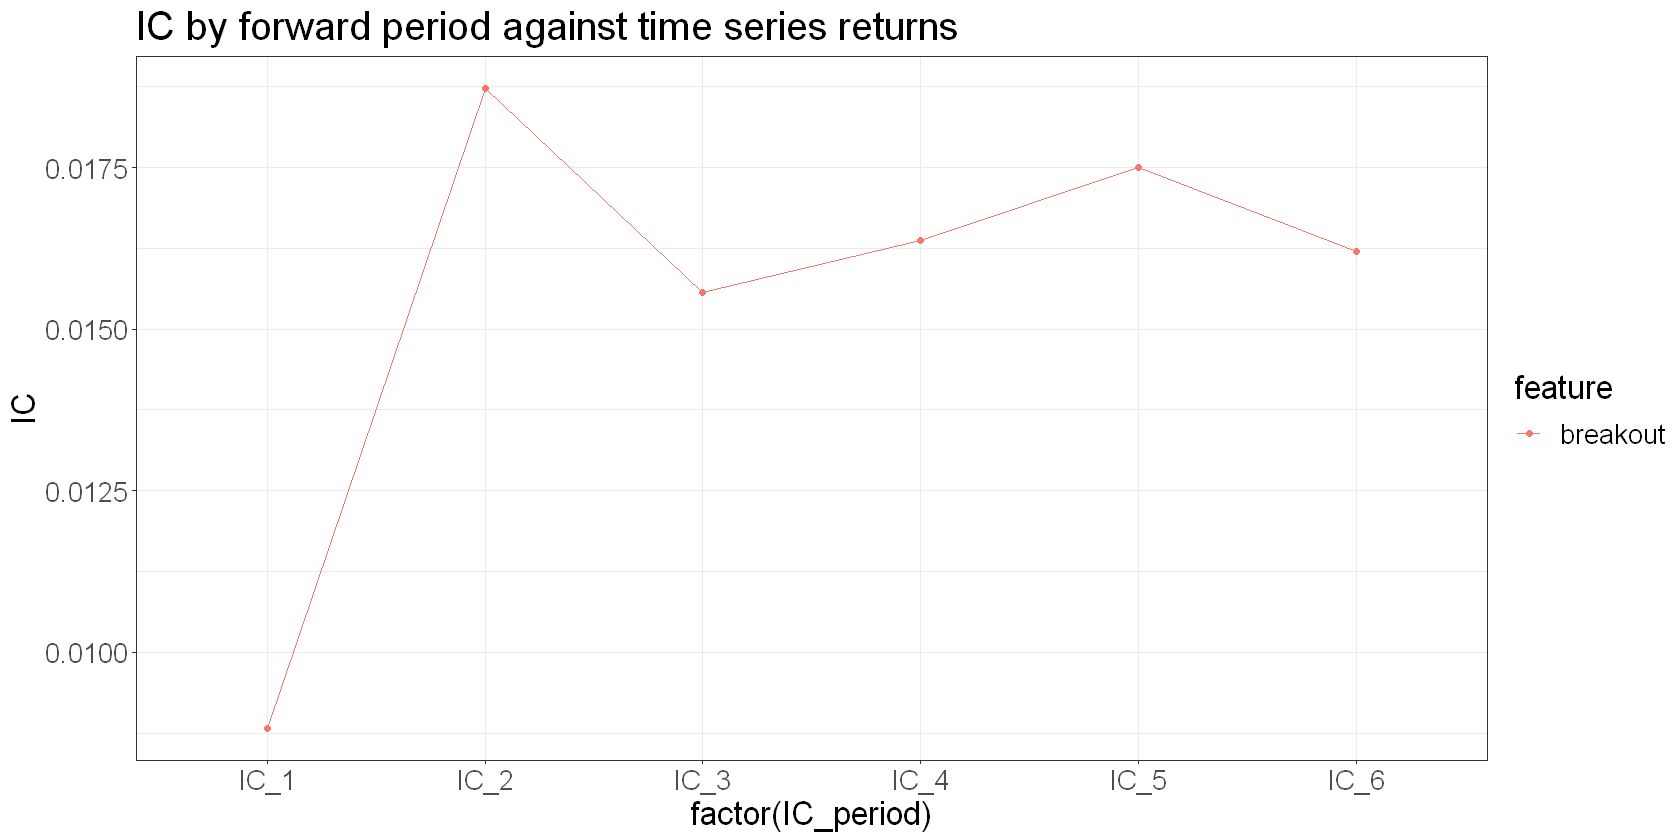

In [172]:
features_scaled %>%
  group_by(date) %>%
  mutate(
    fwd_returns_2 = lead(total_returns_log, 1),
    fwd_returns_3 = lead(total_returns_log, 2),
    fwd_returns_4 = lead(total_returns_log, 3),
    fwd_returns_5 = lead(total_returns_log, 4),
    fwd_returns_6 = lead(total_returns_log, 5),
  ) %>% 
  na.omit() %>% 
  ungroup() %>% 
  pivot_longer(c(breakout), names_to = "feature") %>% 
  group_by(feature) %>% 
  summarize(
    IC_1 = cor(value, total_returns_log),
    IC_2 = cor(value, fwd_returns_2),
    IC_3 = cor(value, fwd_returns_3),
    IC_4 = cor(value, fwd_returns_4),
    IC_5 = cor(value, fwd_returns_5),
    IC_6 = cor(value, fwd_returns_6),
  )  %>% 
  pivot_longer(-feature, names_to = "IC_period", values_to = "IC") %>% 
  ggplot(aes(x = factor(IC_period), y = IC, colour = feature, group = feature)) +
  geom_line() +
  geom_point() +
  labs(
    title = "IC by forward period against time series returns"
  )

In contrast, the breakout feature decays much less slowly. 

In fact, it is stronger from day two onwards than it is on day one - this hints at a time-series mean-reversion effect that might be worth explicitly including in the model as well. 

## Feature correlation 

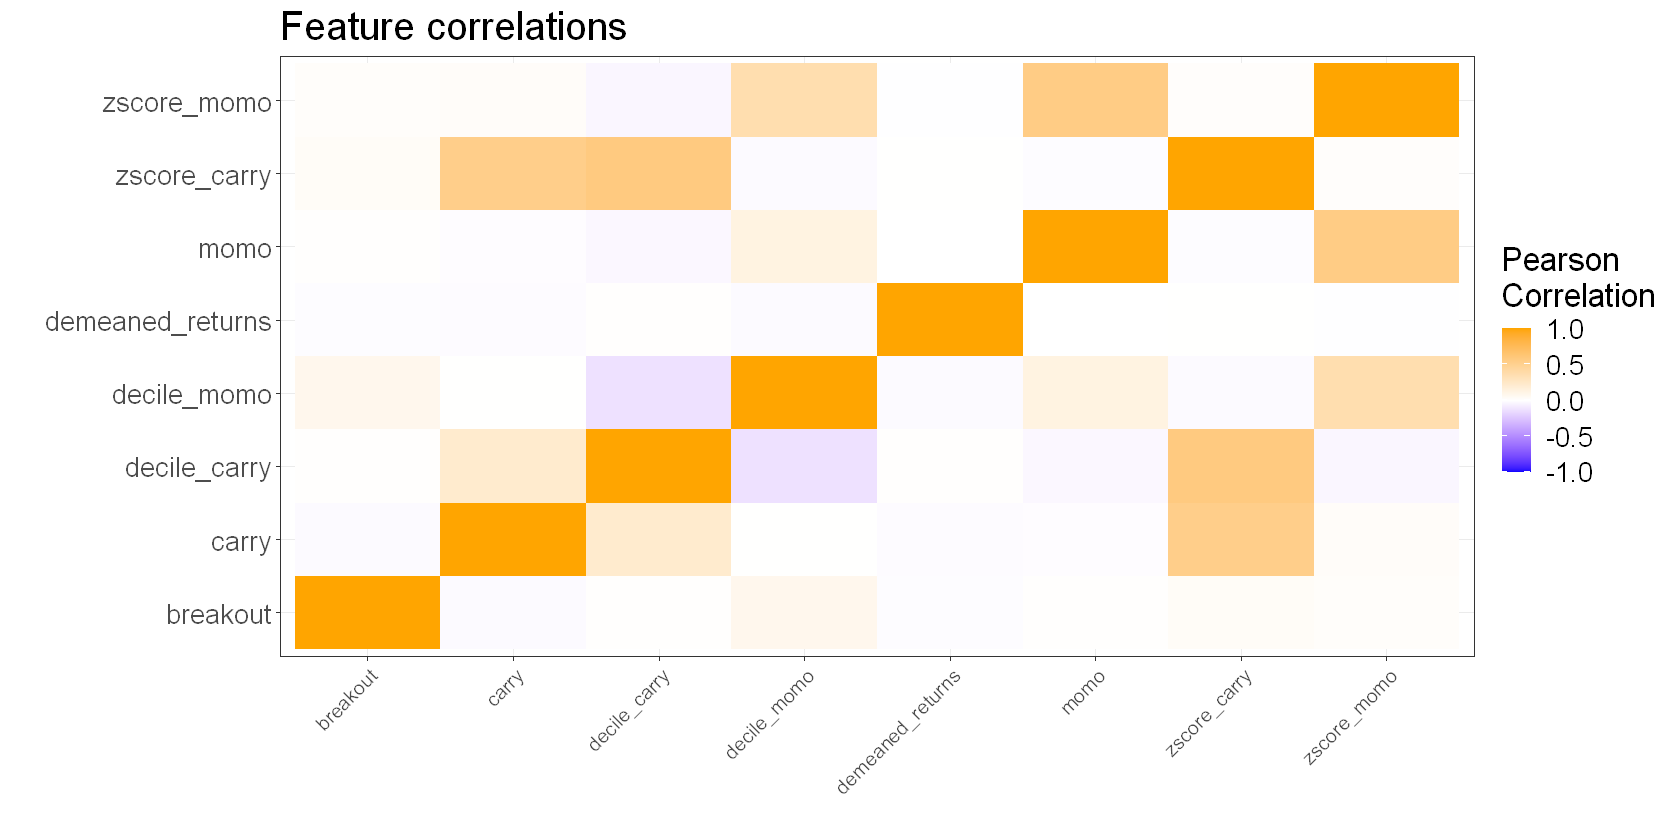

In [191]:
features_scaled %>% 
  select('breakout', 'momo', 'carry', 'demeaned_returns', 'zscore_carry', 'decile_carry', 'zscore_momo', 'decile_momo') %>% 
  as.matrix() %>% 
  cor() %>% 
  as.data.frame() %>% 
  rownames_to_column("feature1") %>% 
  pivot_longer(-feature1, names_to = "feature2", values_to = "corr") %>% 
  ggplot(aes(x = feature1 , y = feature2, fill = corr)) +
  geom_tile() +
  scale_fill_gradient2(
    low = "blue", 
    high = "orange", 
    mid = "white", 
    midpoint = 0, 
    limit = c(-1,1), 
    name="Pearson\nCorrelation"
  ) +
  labs(
    x = "",
    y = "",
    title = "Feature correlations"
  ) +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 12, hjust = 1)) 

This isn't a bad result. We see that our momentum and carry features are negatively correlated, and our breakout feature is almost uncorrelated with everything. That means that we should get some nice diversification from combining these signals. 

## Combining our signals

Based on what we've seen and what we understand about our signals, I think it makes sense to:
- Overweight the `decile_momo` signal, as it has a high IC and is anti-correlated with our other cross-sectional feature. It decays quite quickly. 
- Underweight the `decile_carry` signal, as it has the lowest IC and decays quite quickly.
- Underweight the breakout signal. It has a high IC, decays slowly, and is uncorrelated with the other signals, but it also tilts the portfolio net long or short since it is used in the time series, not the cross-section. 

You might want to weight these signals differently depending on your objectives and constraints, as well as what you understood from a more thorough analysis of each signal. 

In any event, here's a plot of the cumulative returns to our weighted signals over time.  

I want to stress that this isn't a backtest - it makes zero attempt to address the real-world issues such as costs, turnover, or universe restriction. It simply plots the returns to our combined features as if you could do so frictionlessly. 

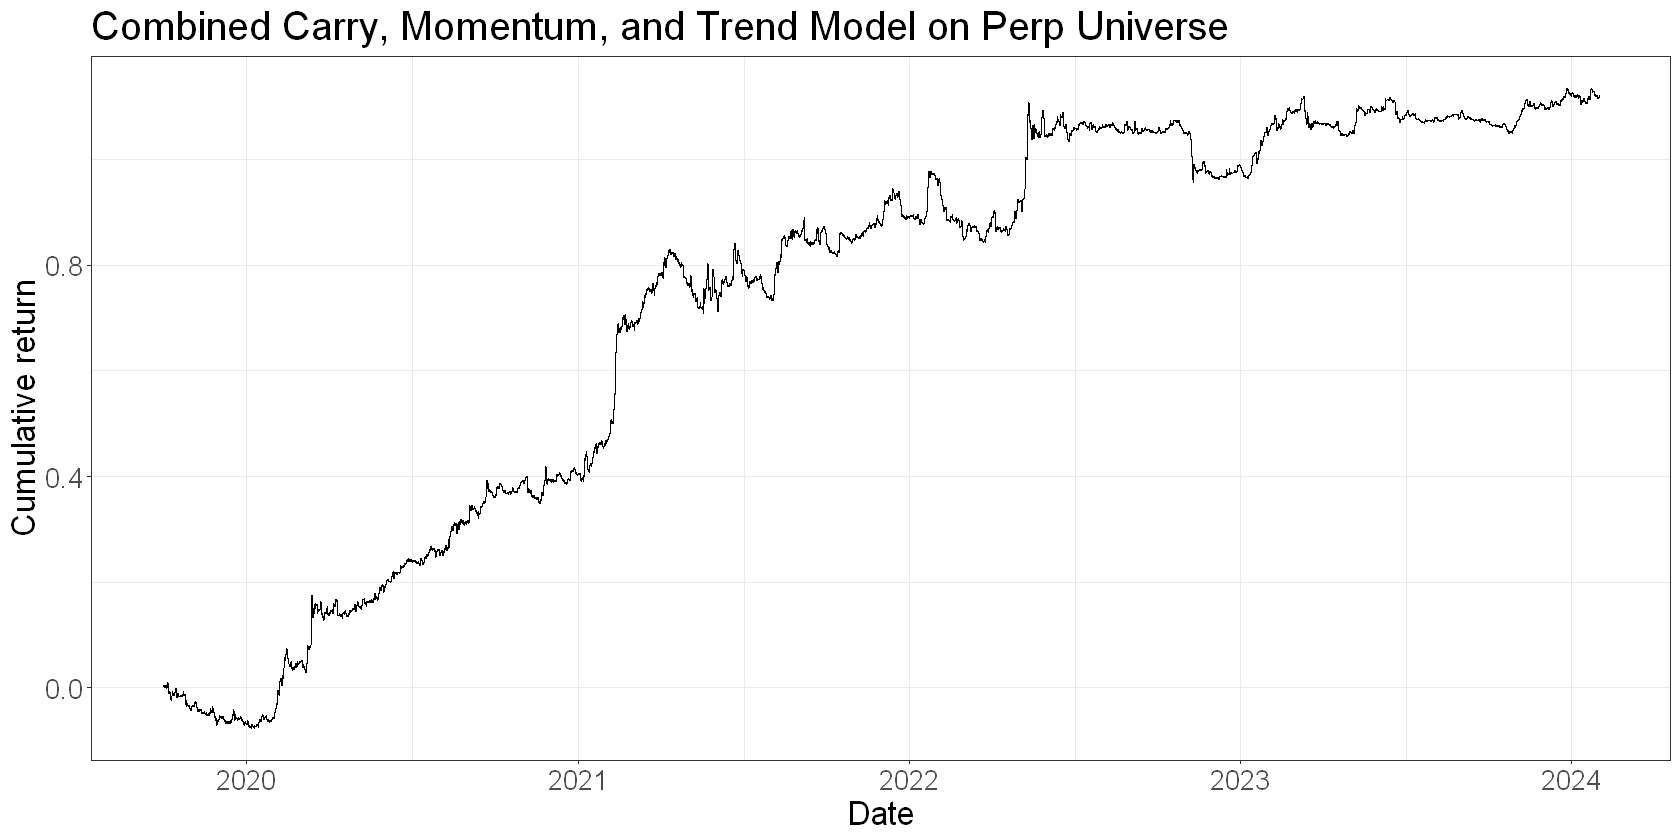

In [202]:
features %>%
  filter(is_universe) %>%
  group_by(date) %>%
  mutate(
    carry_decile = ntile(carry, 10),
    carry_weight = (carry_decile - 5.5)/5,  # will run -4.5 to 4.5
    momo_decile = ntile(momo, 10),
    momo_weight = -(momo_decile - 5.5)/5,  # will run -4.5 to 4.5
    breakout_weight = breakout / 5 , # approx - breakout runs between -9 and 9
    total_weight = (0.3*carry_weight + 0.5*momo_weight + 0.2*breakout_weight) / n()
  ) %>%
  summarize(returns = total_weight * total_returns_simple, .groups = "drop") %>%
  mutate(logreturns = log(returns+1)) %>%
  ggplot(aes(x=date, y=cumsum(logreturns))) + 
  geom_line() + 
  labs(
    title = 'Combined Carry, Momentum, and Trend Model on Perp Universe',
    x = "Date",
    y = "Cumulative return"
  )

## Conclusions

In this article, we looked at ways to understand our signals, and to combine them using a weighting scheme derived from our understanding. 

And let's be honest - the work we did here to understand our signals was very shallow. There's much more you can and should do in order to understand your signals. For example:
- Scatterplots and time-series plots that don't hide the variance
- Stability of factor IC over time 
- Stability of the signal itself and the implications for turnover
- Impact of taking the tails only 
- etc

In the next article, we'll tackle the questions of turnover and cost and resort to a constrained mean-variance optimisation to help us navigate these trade-offs. 